# Step 1
#### Importing required libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
#from sklearn.lda import LDA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import StratifiedKFold
from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve
from sklearn.metrics import confusion_matrix
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures
import warnings
import seaborn as sn
warnings.filterwarnings('ignore')

/home/stush/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/stush/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/stush/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


#### Functions to be used

In [2]:
def displayall(df):
    """
    Setting the maximum rows and columns to to 1000.
    This is to enable us view all the features in the data set
    
    """
    with pd.option_context("display.max_rows",1000):
        with pd.option_context("display.max_columns",1000):
            display(df)

def add_interactions(df):
    #Get feature names
    combos = list(combinations(list(df.columns),2))
    colnames = list(df.columns)+['_'.join(x) for x in combos]
    
    #find interactions
    poly = PolynomialFeatures(interaction_only = True,include_bias = False)
    df = poly.fit_transform(df)
    df=pd.DataFrame(df)
    df.columns = colnames
    
    #remove intercation terms with all 0 values
    noint_indicies = [i for i,x in enumerate(list((df==0).all())) if x]
    df = df.drop(df.columns[noint_indicies],axis = 1)
    
    return df

# Step 2
#### Import the data

In [3]:
data = pd.read_csv('/home/stush/Personal Projects/master/data/modelling_data.csv')

# Step 3
#### Clean the data for modelling

In [4]:
#Display all columns
data.columns

Index(['ClientID', 'Loans', 'DefaultedLoans', 'NonPerformingLoans',
       'AvgLoanAmount', 'LastLoanAmount', 'LastLoanPeriod', 'Lending',
       'AvgLendingAmount', 'LastLendingAmount', 'LastLoanOn', 'LastDefaultOn',
       'Createdon', 'Defaulted >  10 Days', 'LastDefault > 10 On',
       'LastRepaymentOn', 'MaxLoanAmount', 'LastDefault > 2on', 'Defaulted>2',
       'CRBListed', 'grade', 'MobileLoansScore',
       'avgMobiLoanPrincipalAmountmySector', 'creditHistorymySector',
       'creditHistoryotherSector', 'lastMobiLoanPrincipalAmountotherSector',
       'maxMobiLoanPrincipalAmountotherSector', 'paAccountsmySector',
       'paAccountsotherSector', 'npaAccountsmySector',
       'npaAccountsotherSector', 'paAccountsWithDhmySector',
       'paAccountsWithDhotherSector', 'LastLoanOnYear', 'LastLoanOnMonth',
       'LastLoanOnDay', 'LastLoanOnDayofweek', 'LastLoanOnIs_month_end',
       'LastLoanOnIs_month_start', 'LastLoanOnIs_quarter_end',
       'LastLoanOnIs_quarter_start', 'LastL

In [5]:
#Drop clientID column as its not needed
model_df_v1 = data.drop(['ClientID'],axis = 1)

In [6]:
# displayall(model_df_v1.head())

In [7]:
#Drop all date columns and grade columns. All these columns were expanded/encode
model_df_v2 = model_df_v1.drop(['LastDefault > 2on','LastLoanOn','Createdon','LastRepaymentOn','grade','LastDefault > 10 On','LastDefaultOn'],axis = 1)

In [8]:
model_df_v2 = model_df_v2[model_df_v2.NonPerformingLoans!=2]

In [9]:
model_df_v2.shape

(9040, 48)

# Step 4
#### Seperate the X variable from the Y variable in the data set

In [10]:
y = model_df_v2['NonPerformingLoans'].values.reshape(-1)

In [11]:
X1 = model_df_v2.drop(['NonPerformingLoans'],axis = 1)

In [12]:
X2 = add_interactions(X1)

In [13]:
# Create correlation matrix
corr_matrix = X2.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [14]:
X2.shape

(9040, 916)

In [15]:
X = X2.drop(X2[to_drop], axis=1)

In [16]:
X.shape

(9040, 639)

In [17]:
y.shape

(9040,)

# Step 5
#### Preprocessing

In [18]:
#Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35)

# Step 6
#### Modelling 

In [19]:
# First define the pipeline

forest = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=30)),
                    ('clf', RandomForestClassifier(criterion='entropy',
                                                   n_estimators=10,
                                                   n_jobs=2,
                                                   random_state=1))])

#Pipeline without PCA
NoPCA_forest = Pipeline([('scl', StandardScaler()),
                    ('clf', RandomForestClassifier(criterion='entropy',
                                                   n_estimators=10,
                                                   n_jobs=2,
                                                   random_state=1))])

In [20]:
#Fitting the model and printing the output
forest.fit(X_train, y_train)
print('Test Accuracy: %.3f' % forest.score(X_test, y_test))

Test Accuracy: 0.864


In [21]:
y_pred = forest.predict(X_test)

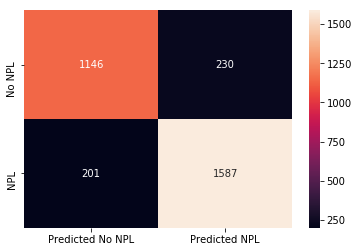

In [22]:
cm = np.array(confusion_matrix(y_true=y_test, y_pred=y_pred))
confusion = pd.DataFrame(cm,index =['No NPL','NPL'],columns = ['Predicted No NPL','Predicted NPL'])  
sn.heatmap(confusion,annot = True,fmt ='d')

In [23]:
#Fitting the model and printing the output
NoPCA_forest.fit(X_train, y_train)
print('Test Accuracy: %.3f' % NoPCA_forest.score(X_test, y_test))

Test Accuracy: 0.955


In [24]:
y_pred_NoPCA = NoPCA_forest.predict(X_test)

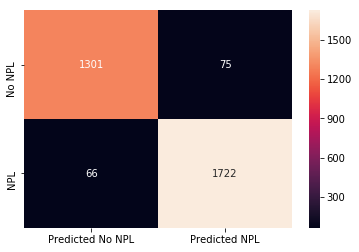

In [25]:
cm_NoPCA = np.array(confusion_matrix(y_true=y_test, y_pred=y_pred_NoPCA))
confusion_NoPCA = pd.DataFrame(cm_NoPCA,index =['No NPL','NPL'],columns = ['Predicted No NPL','Predicted NPL']) 
sn.heatmap(confusion_NoPCA,annot = True,fmt ='d')

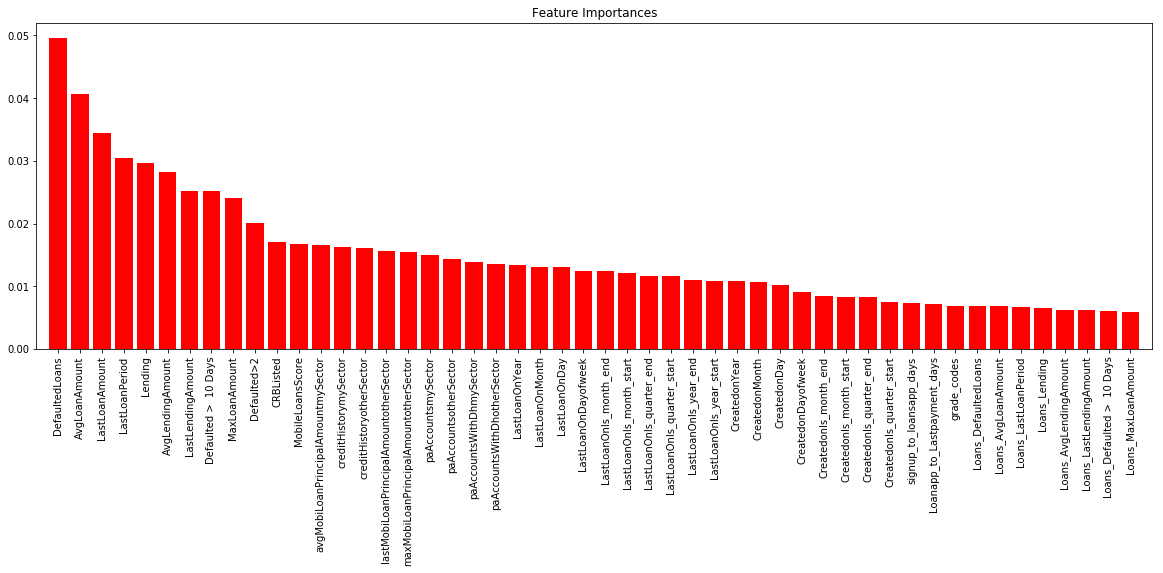

In [31]:
feat_labels = X_train.columns[1:]
importances = NoPCA_forest.steps[1][1].feature_importances_
indices = np.argsort(importances)[::-1]
top_k = 50
new_indices = indices[:top_k]


plt.figure(figsize = (20,6))
plt.title('Feature Importances')
plt.bar(range(top_k), importances[new_indices],
       color="r", align="center")
plt.xticks(range(top_k),feat_labels, rotation=90)
plt.xlim([-1, top_k])
plt.show()

In [26]:
#Cross validation score
scores = cross_val_score(estimator=NoPCA_forest,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)

In [27]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

CV accuracy: 0.958 +/- 0.009


In [28]:
train_sizes, train_scores, test_scores =learning_curve(estimator=NoPCA_forest,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=1)

In [29]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

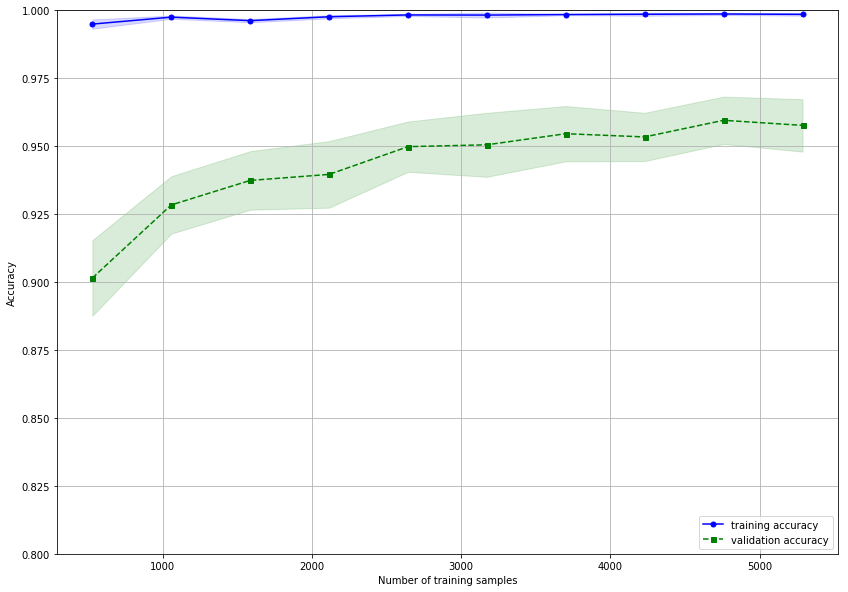

In [32]:
plt.figure(figsize = (14,10))


plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5,
         label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

In [42]:
param_range = np.arange(1, 11)
train_scores2, test_scores2 = validation_curve(estimator=NoPCA_forest,
                                             X=X_train,
                                             y=y_train,
                                             param_name='clf__max_depth',
                                             param_range=np.arange(1, 11),
                                             cv=10)

In [43]:
train_mean2 = np.mean(train_scores2, axis=1)
train_std2 = np.std(train_scores2, axis=1)
test_mean2 = np.mean(test_scores2, axis=1)
test_std2 = np.std(test_scores2, axis=1)

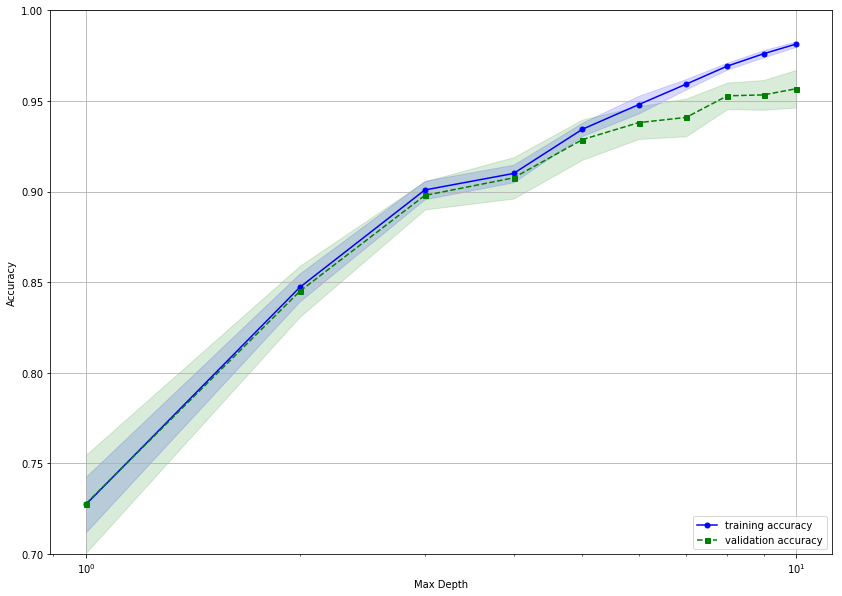

In [46]:
plt.figure(figsize = (14,10))

plt.plot(param_range, 
         train_mean2,
         color='blue', 
         marker='o',
         markersize=5,
         label='training accuracy')

plt.fill_between(param_range, 
                 train_mean2 + train_std2,
                 train_mean2 - train_std2, alpha=0.15,
                 color='blue')

plt.plot(param_range, 
         test_mean2,
         color='green', 
         linestyle='--',
         marker='s', 
         markersize=5,
         label='validation accuracy')

plt.fill_between(param_range,
                 test_mean2 + test_std2,
                 test_mean2 - test_std2,
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1.0])
plt.show()